# FPL Ideal Team

In Fantasy Premier League (FPL), you select a fantasy football squad of 15 players, consisting of:
- 2 Goalkeepers
- 5 Defenders
- 5 Midfielders
- 3 Forwards

Each player has a price, and the total value of your initial squad must not exceed £100 million. You can select no more than 3 players from a single Premier League team.

## FPL Ideal Team Model

In this notebook I created a model that creates an ideal FPL team based on each player's last season ROI (Return on Investment), or in other words, how many points a player returns for every £1 invested in them.

*Why ROI?*
- A high ROI means the investment's gains (points scored) compare favourably to its cost. As a performance measure, ROI is used to evaluate the efficiency of an investment.

## Index
* [Data](#data)
* [ROI](#ROI)
* [Ideal Team](#ideal-team)

In [3]:
#Import relevant libraries and packages
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import os
import sys
from pathlib import Path
from IPython.display import FileLink, FileLinks

## Data <a class="anchor" id="data"></a>

In [6]:
#Path to data directory
path = Path('fpl_model/Data')

#Import player stats dataset (since 2016-17 PL Season)
data = pd.read_csv(path/'training_data.csv', 
                       index_col=0, 
                       dtype={'season':str,
                              'squad':str,
                              'comp':str})

#Select data from last season
data_2122 = data[data['season'] == '2122']

#Player data from this season
players_2223 = pd.read_csv(path/'2022-23/cleaned_players.csv')

#Player data from last season
players_2122 = pd.read_csv(path/'2021-22/cleaned_players.csv')

The original data has one row per player, per gameweek, for each player and gameweek since the 2016-2017 season; however, I only use the data from the 2021-22 PL season.

I create a dataframe with each player, team, position in the 2022-23 PL season, FPL cost in the 2021-22 season, FPL cost in the 2022-23 season, total minutes played in the 2021-22 season, total_points scored in the 2021-22 PL season, and their ROI (Return on Investment).

**Note: I drop players from relegated teams, as they will not be available this season's FPL. I also drop some players with high ROI values that were transferred to other teams and are not expected to have as many minutes as they had last season.*

In [7]:
#Adjust 2022-23 players dataframe - get players' full names and keep relevant columns (cost and position)
players_2223['player'] = players_2223['first_name'] + ' ' + players_2223['second_name']
players_2223 = players_2223.set_index('player')
players_2223 = players_2223.drop(['first_name', 'second_name'], axis=1)
players_2223 = players_2223[['now_cost', 'element_type']]

#Adjust 2021-22 dataframe - group data by team and player, and keep relevant columns (total_points and minutes)
data_player = data_2122.groupby(['player', 'team']).sum()
data_player = data_player.reset_index()
data_player = data_player[['player', 'team','total_points', 'minutes']]

#Merge 2021-22 and 2022-23 players dataframes and rename relevant columns
data_with_cost = data_player.merge(players_2223, on = 'player')
data_with_cost = data_with_cost.rename({'element_type': 'position', 'now_cost': 'cost_2223'}, axis=1)
data_with_cost = data_with_cost.astype(str)

#Adjust cost values to represent actual FPL costs
for index, row in data_with_cost.iterrows():
    if (len(row['cost_2223'])) == 3:
        row['cost_2223'] = (row['cost_2223'][:2] + '.' + row['cost_2223'][2:])
    if (len(row['cost_2223'])) == 2:
        row['cost_2223'] = (row['cost_2223'][:1] + '.' + row['cost_2223'][1:])
        
data_with_cost['total_points'] = data_with_cost['total_points'].astype(int)
data_with_cost['cost_2223'] = data_with_cost['cost_2223'].astype(float)

#Adjust 2021-22 players dataframe - get players' full names and keep cost column
players_2122['player'] = players_2122['first_name'] + ' ' + players_2122['second_name']
players_2122 = players_2122.set_index('player')
players_2122 = players_2122.drop(['first_name', 'second_name'], axis=1)
players_2122 = players_2122[['now_cost']]
players_2122 = players_2122.astype(str)

#Adjust cost values to represent actual FPL costs
for index, row in players_2122.iterrows():
    if (len(row['now_cost'])) == 3:
        row['now_cost'] = (row['now_cost'][:2] + '.' + row['now_cost'][2:])
    if (len(row['now_cost'])) == 2:
        row['now_cost'] = (row['now_cost'][:1] + '.' + row['now_cost'][1:])

#Merge 2021-22 and 2022-23 players dataframe with 2021-22 players dataframe, rename and reorder columns
data_with_cost = data_with_cost.merge(players_2122, on = 'player')
data_with_cost = data_with_cost.rename({'now_cost': 'cost_2122'}, axis=1)
data_with_cost = data_with_cost[['player', 'team', 'position', 'cost_2122', 'cost_2223','minutes','total_points']]
data_with_cost['cost_2122'] = data_with_cost['cost_2122'].astype(float)
data_with_cost['minutes'] = data_with_cost['minutes'].astype(int)
#We keep players who played at least half of games
data_with_cost = data_with_cost[data_with_cost['minutes'] >= (38/2)*90]

#Dropping relegated teams and some players
data_with_cost = data_with_cost[data_with_cost['player'] != 'Armando Broja']
data_with_cost = data_with_cost[data_with_cost['player'] != 'Conor Gallagher']
data_with_cost = data_with_cost[data_with_cost['team'] != 'Norwich']
data_with_cost = data_with_cost[data_with_cost['team'] != 'Burnley']
data_with_cost = data_with_cost[data_with_cost['team'] != 'Watford']

In [9]:
#Add ROI (Return On Investment) to dataframe, where ROI is total points / cost
data_with_cost['ROI'] = data_with_cost['total_points']/data_with_cost['cost_2122']

#Only keep players with ROI values greater than 0
data_with_cost = data_with_cost[data_with_cost['ROI'] > 0]

#Sort table values by ROI
ROI_top_players = data_with_cost.sort_values('ROI', ascending=False)
ROI_top_players = ROI_top_players.reset_index()
ROI_top_players = ROI_top_players.drop('index', axis=1)
ROI_top_players

,player,team,position,cost_2122,cost_2223,minutes,total_points,ROI
0,Joel Matip,Liverpool,DEF,5.3,6.0,2700,163,30.754717
1,Jarrod Bowen,West Ham United,MID,6.9,8.5,2897,204,29.565217
2,Conor Coady,Wolverhampton Wanderers,DEF,4.7,4.9,3271,137,29.148936
3,Alisson Ramses Becker,Liverpool,GK,6.1,5.5,3150,173,28.360656
4,José Malheiro de Sá,Wolverhampton Wanderers,GK,5.2,5.0,3240,145,27.884615
...,...,...,...,...,...,...,...,...
146,Jamaal Lascelles,Newcastle United,DEF,4.4,4.4,1965,45,10.227273
147,Jadon Sancho,Manchester United,MID,8.9,7.4,1894,91,10.224719
148,Ben Godfrey,Everton,DEF,4.7,4.4,2029,45,9.574468
149,Aaron Wan-Bissaka,Manchester United,DEF,5.1,4.4,1793,41,8.039216


I also create a dataframe that contains the same data as above, but this time, sorted by total_points:

In [14]:
#Same dataframe with players sorted by total points
points_top_players = ROI_top_players.sort_values('total_points', ascending = False)
points_top_players = points_top_players.reset_index()
points_top_players = points_top_players.drop('index', axis=1)
points_top_players

,player,team,position,cost_2122,cost_2223,minutes,total_points,ROI
0,Mohamed Salah,Liverpool,MID,13.1,13.0,2726,259,19.770992
1,Trent Alexander-Arnold,Liverpool,DEF,8.4,7.5,2763,206,24.523810
2,Jarrod Bowen,West Ham United,MID,6.9,8.5,2897,204,29.565217
3,Kevin De Bruyne,Manchester City,MID,12.1,12.1,2106,190,15.702479
4,Virgil van Dijk,Liverpool,DEF,6.8,6.5,3060,183,26.911765
...,...,...,...,...,...,...,...,...
146,Luke Thomas,Leicester City,DEF,4.3,4.5,1911,50,11.627907
147,Jamaal Lascelles,Newcastle United,DEF,4.4,4.4,1965,45,10.227273
148,Ben Godfrey,Everton,DEF,4.7,4.4,2029,45,9.574468
149,Aaron Wan-Bissaka,Manchester United,DEF,5.1,4.4,1793,41,8.039216


## ROI - Return on Investment <a class="anchor" id="ROI"></a>

Let's look at some ROI statistics.

### Average ROI per team:

In [15]:
#Average ROI per team
team_averages = ROI_top_players.groupby('team').mean().sort_values('ROI', ascending=False)['ROI'].to_frame()
team_averages

,ROI
team,
Liverpool,24.321537
Brentford,21.233736
Wolverhampton Wanderers,21.177581
Tottenham Hotspur,21.143728
Arsenal,20.551240
West Ham United,20.239105
Crystal Palace,19.916084
Chelsea,19.458348
Brighton and Hove Albion,19.091665


### Average ROI per position:

In [16]:
#Average ROI per position
position_averages = ROI_top_players.groupby('position').mean().sort_values('ROI', ascending=False)['ROI'].to_frame()
position_averages

,ROI
position,
GK,24.033653
DEF,18.873236
MID,17.858272
FWD,15.603448


## Ideal Team <a class="anchor" id="ideal_team"></a>

The algorithm below returns an ideal team according to each player's **ROI** from last season. The team fulfills the position requirements (2 goalkeepers, 5 defenders, 5 midfielders, and 3 forwards), the team requirements (no more than 3 players per team), and the budget requirements (squad value must not exceed £100 million).

In [46]:
#Ideal team
#Choose players with a budget of 100 based on best ROI
def get_ideal_team_ROI(budget = 100, gk = 2, df = 5, md = 5, fwd = 3, team_max = 3):
    money_team = []
    budget = budget
    positions = {'GK': gk, 'DEF': df, 'MID': md, 'FWD': fwd}
    teams = {'Arsenal': team_max, 'Leeds': team_max, 'Manchester City': team_max, 
             'Tottenham Hotspur': team_max, 'Liverpool': team_max, 'Southampton': team_max, 
             'Chelsea': team_max, 'Brentford': team_max, 'Nottingham Forest': team_max, 
             'Wolverhampton Wanderers': team_max, 'Aston Villa': team_max, 
             'Crystal Palace': team_max, 'West Ham United': team_max, 'Leicester City': team_max, 
             'Newcastle United': team_max, 'Bournemouth': team_max, 'Everton': team_max, 
             'Brighton and Hove Albion': team_max, 
             'Manchester United': team_max, 'Fulham': team_max}
    t1 = ROI_top_players.iterrows()
    for i, row in t1:
        if (budget >= row['cost_2223'] and positions[row['position']] > 0
            and teams[row['team']] > 0):
                money_team.append(row['player'])
                budget -= row['cost_2223']
                positions[row['position']] = positions[row['position']] - 1
                teams[row['team']] = teams[row['team']] - 1
    return money_team

money_team_ROI = pd.DataFrame(get_ideal_team_ROI()) 

In [47]:
#Make ideal team into dataframe and add relevant columns
ideal_team_ROI = money_team_ROI.rename({0: 'player'}, axis=1)
ideal_team_ROI = ideal_team_ROI.merge(ROI_top_players, on='player')
ideal_team_ROI.position = pd.Categorical(ideal_team_ROI.position, categories=['GK', 'DEF', 'MID', 'FWD'])
ideal_team_ROI = ideal_team_ROI.sort_values('position')
ideal_team_ROI = ideal_team_ROI.reset_index().drop('index', axis=1)
ideal_team_ROI

,player,team,position,cost_2122,cost_2223,minutes,total_points,ROI
0,Alisson Ramses Becker,Liverpool,GK,6.1,5.5,3150,173,28.360656
1,José Malheiro de Sá,Wolverhampton Wanderers,GK,5.2,5.0,3240,145,27.884615
2,Joel Matip,Liverpool,DEF,5.3,6.0,2700,163,30.754717
3,Conor Coady,Wolverhampton Wanderers,DEF,4.7,4.9,3271,137,29.148936
4,Marc Guéhi,Crystal Palace,DEF,4.5,4.5,3222,123,27.333333
5,Virgil van Dijk,Liverpool,DEF,6.8,6.5,3060,183,26.911765
6,Pontus Jansson,Brentford,DEF,4.5,4.5,3231,121,26.888889
7,Jarrod Bowen,West Ham United,MID,6.9,8.5,2897,204,29.565217
8,Bukayo Saka,Arsenal,MID,6.7,8.0,2901,174,25.970149
9,James Maddison,Leicester City,MID,6.9,8.0,2373,168,24.347826


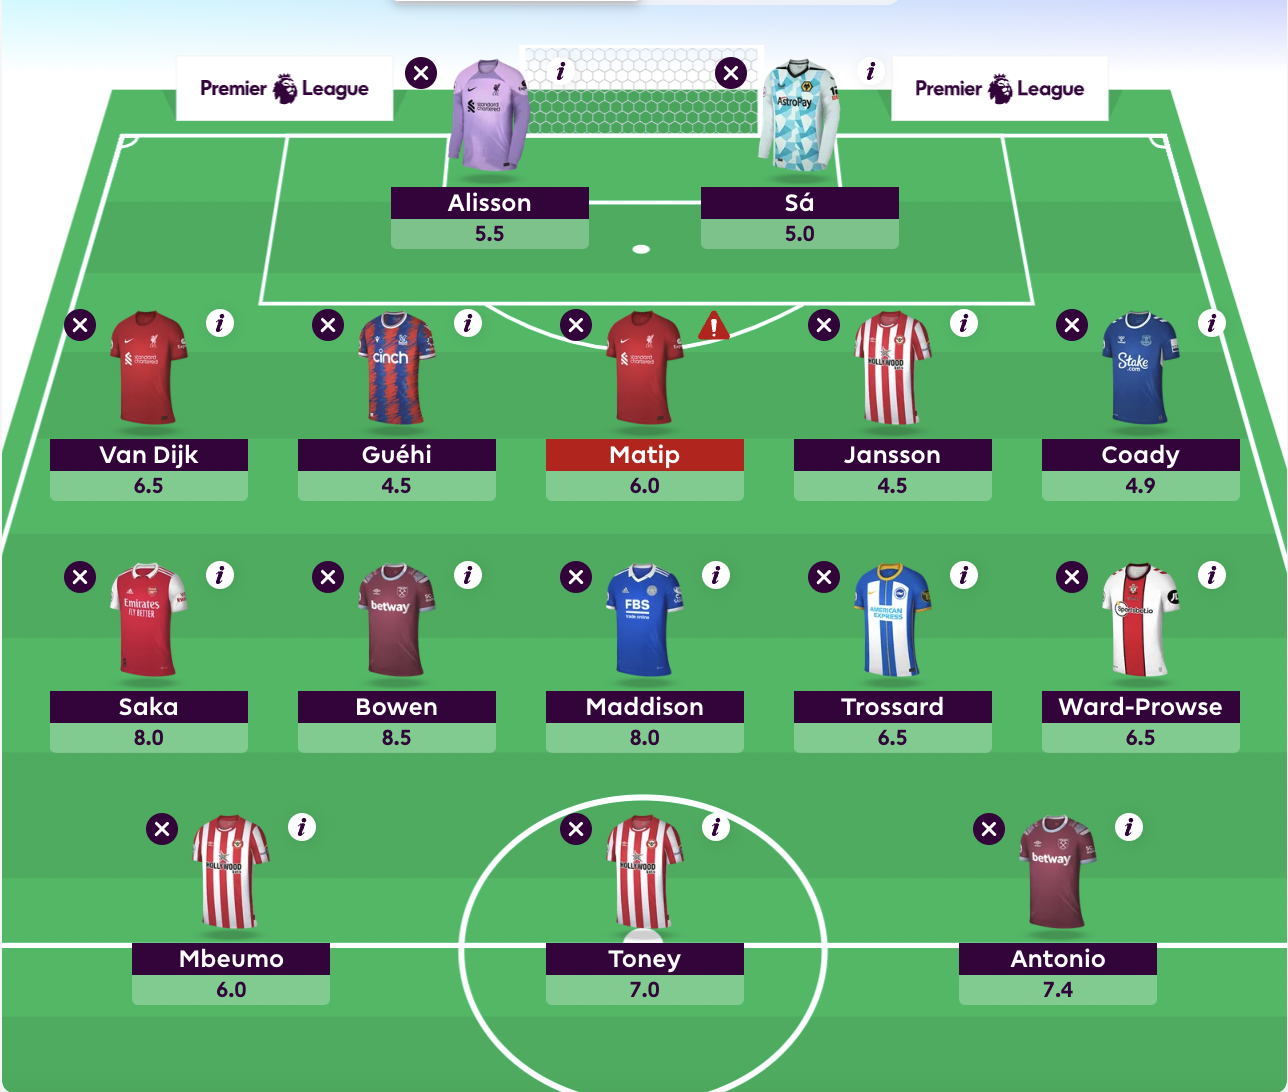